In [204]:
import pandas as pd
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import datetime as dt
import os
from google.cloud import bigquery

nltk.download('vader_lexicon')

DATA_DIR = 'dsa_airflow/data'
tweets_file = 'raw_twitter.csv'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/chloe_ycl/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Scape Data from Twitter and save to dataframe

In [237]:
tweets_list = []
until = dt.datetime.strftime(dt.date.today(), '%Y-%m-%d')
since = dt.datetime.strftime(dt.datetime.strptime(until, '%Y-%m-%d') - dt.timedelta(days=31), '%Y-%m-%d')
# -exclude:retweetedTweet
query = f'$TSLA lang:en until:{until} since:{since} -filter:links -filter:replies -is:retweet -is:nullcast -from:Daily__Alerts'
n_tweets = 25000

for i, tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(query).get_items()), total=n_tweets):
  tweets_list.append([tweet.date, tweet.id, tweet.rawContent, tweet.user, tweet.cashtags])
  if i > n_tweets:
      break
    
#Creating a dataframe from the tweets list above 
df = pd.DataFrame(tweets_list, columns=['date', 'id', 'content', 'user','cashtag'])

df.head(5)
  
# df.to_csv(os.path.join(DATA_DIR, 'raw_twitter.csv'), header=True, index=False)
# print(f"saved")
# df = pd.read_csv(os.path.join(DATA_DIR, tweets_file), header=0)

 95%|█████████▍| 23715/25000 [13:24<00:43, 29.46it/s]


,date,id,content,user,cashtag
0,2023-03-06 23:58:27+00:00,1632893434695434240,Can't bring myself to draw out charts tonight....,https://twitter.com/steviestonk,"[AAPL, TSLA, NVDA]"
1,2023-03-06 23:55:06+00:00,1632892593133477889,I swear big moves happen when things are not f...,https://twitter.com/Mars_Float,"[TSLA, TSLA, SPY, QQQ]"
2,2023-03-06 23:49:48+00:00,1632891260649324548,$tsla $tslaq pair trade.. any thoughts ?,https://twitter.com/AleksDudic01,"[tsla, tslaq]"
3,2023-03-06 23:48:47+00:00,1632891004654170112,At this point I might just bet on $GME to go u...,https://twitter.com/Mars_Float,"[GME, TSLA]"
4,2023-03-06 23:36:01+00:00,1632887792542908416,1 month ago we saw $210 a share and we said we...,https://twitter.com/Mars_Float,[TSLA]


### Transformation
- Change columns dtypes 
- Clean up [content] column
- Drop [cashtags] column
- Change [date] column format

In [238]:
df.dtypes 

date       datetime64[ns, UTC]
id                       int64
content                 object
user                    object
cashtag                 object
dtype: object

In [239]:
df = df.drop(columns=['cashtag'])

df['date']= df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.head(5)


,date,id,content,user
0,2023-03-06,1632893434695434240,Can't bring myself to draw out charts tonight....,https://twitter.com/steviestonk
1,2023-03-06,1632892593133477889,I swear big moves happen when things are not f...,https://twitter.com/Mars_Float
2,2023-03-06,1632891260649324548,$tsla $tslaq pair trade.. any thoughts ?,https://twitter.com/AleksDudic01
3,2023-03-06,1632891004654170112,At this point I might just bet on $GME to go u...,https://twitter.com/Mars_Float
4,2023-03-06,1632887792542908416,1 month ago we saw $210 a share and we said we...,https://twitter.com/Mars_Float


In [240]:
df[['year', 'month', 'day']] = df.date.str.split("-", expand=True)
print(df.dtypes)
df.head(5)

date       object
id          int64
content    object
user       object
year       object
month      object
day        object
dtype: object


,date,id,content,user,year,month,day
0,2023-03-06,1632893434695434240,Can't bring myself to draw out charts tonight....,https://twitter.com/steviestonk,2023,03,06
1,2023-03-06,1632892593133477889,I swear big moves happen when things are not f...,https://twitter.com/Mars_Float,2023,03,06
2,2023-03-06,1632891260649324548,$tsla $tslaq pair trade.. any thoughts ?,https://twitter.com/AleksDudic01,2023,03,06
3,2023-03-06,1632891004654170112,At this point I might just bet on $GME to go u...,https://twitter.com/Mars_Float,2023,03,06
4,2023-03-06,1632887792542908416,1 month ago we saw $210 a share and we said we...,https://twitter.com/Mars_Float,2023,03,06


In [243]:
df = df.astype({'date': 'datetime64[ns]', 'content':'string', 'user': 'string', 'year':'int64', 'month': 'int64','day': 'int64'})

In [244]:
df.dtypes

date       datetime64[ns]
id                  int64
content            string
user               string
year                int64
month               int64
day                 int64
dtype: object

In [253]:
# Create a function to clean the tweets
def clean_text(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('\n', '', text) # Removing \n
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    return text 

In [254]:
def get_tweet_sentiment(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using SentimentIntensityAnalyzer's sentiment method
    '''
    # create SentimentIntensityAnalyzer object of passed tweet text
    # return a dict of results
    SIA_obj = SentimentIntensityAnalyzer()
    analysis = SIA_obj.polarity_scores(tweet)

    # decide sentiment as positive, negative and neutral
    if analysis['neg'] > analysis['pos']:
        return 'negative'
    elif analysis['neg'] < analysis['pos']:
        return 'positive'
    else:
        return 'neutral'

In [255]:
def get_tweet_sentiment_score(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using SentimentIntensityAnalyzer's sentiment method
    '''
    # create SentimentIntensityAnalyzer object of passed tweet text
    # return a dict of results
    SIA_obj = SentimentIntensityAnalyzer()
    analysis = SIA_obj.polarity_scores(tweet)

    # decide sentiment as positive, negative and neutral
    if analysis['neg'] > analysis['pos']:
        return analysis['neg']
    elif analysis['neg'] < analysis['pos']:
        return analysis['pos']
    else:
        return analysis['neu']

In [258]:
df['content'] = df['content'].apply(clean_text)

df = df.drop(columns=['content_test', 'content_test_v2'])
df.head(5)

,date,id,content,user,year,month,day
0,2023-03-06,1632893434695434240,Can't bring myself to draw out charts tonight....,https://twitter.com/steviestonk,2023,3,6
1,2023-03-06,1632892593133477889,I swear big moves happen when things are not f...,https://twitter.com/Mars_Float,2023,3,6
2,2023-03-06,1632891260649324548,$tsla $tslaq pair trade.. any thoughts ?,https://twitter.com/AleksDudic01,2023,3,6
3,2023-03-06,1632891004654170112,At this point I might just bet on $GME to go u...,https://twitter.com/Mars_Float,2023,3,6
4,2023-03-06,1632887792542908416,1 month ago we saw $210 a share and we said we...,https://twitter.com/Mars_Float,2023,3,6


In [259]:
df['sentiment'] = df['content'].apply(get_tweet_sentiment)

df['score'] = df['content'].apply(get_tweet_sentiment_score)

df.head(10)

,date,id,content,user,year,month,day,sentiment,score
0,2023-03-06,1632893434695434240,Can't bring myself to draw out charts tonight....,https://twitter.com/steviestonk,2023,3,6,positive,0.228
1,2023-03-06,1632892593133477889,I swear big moves happen when things are not f...,https://twitter.com/Mars_Float,2023,3,6,negative,0.050
2,2023-03-06,1632891260649324548,$tsla $tslaq pair trade.. any thoughts ?,https://twitter.com/AleksDudic01,2023,3,6,neutral,1.000
3,2023-03-06,1632891004654170112,At this point I might just bet on $GME to go u...,https://twitter.com/Mars_Float,2023,3,6,negative,0.227
4,2023-03-06,1632887792542908416,1 month ago we saw $210 a share and we said we...,https://twitter.com/Mars_Float,2023,3,6,positive,0.121
5,2023-03-06,1632886626912202753,$XLV should do a minimum reaction higher towar...,https://twitter.com/EWFTaha,2023,3,6,positive,0.147
6,2023-03-06,1632886017731743746,I see the quality control on my $TSLA and the ...,https://twitter.com/HooliganTrades,2023,3,6,positive,0.121
7,2023-03-06,1632885885405663233,I’m ready to go down with the ship!!! $TSLA!!,https://twitter.com/ernsierrax,2023,3,6,positive,0.314
8,2023-03-06,1632885182771372034,best long term stocks to invest in anyone? new...,https://twitter.com/jaroworld1,2023,3,6,positive,0.244
9,2023-03-06,1632883529074835459,I legit only trade $NVDA $TSLA $AAPL n its bee...,https://twitter.com/artgotit,2023,3,6,positive,0.339


In [149]:
# df.to_csv(os.path.join(DATA_DIR, 'raw_twitter.csv'), header=True, index=False)

In [260]:
PROJECT_ID = 'deb-01-372112'
DATASET_ID = 'SIA_Stocks'

# create bigquery client
client = bigquery.Client()

# create table
table_id = "{}.SIA_Stocks.twitter".format(client.project)

schema = [
    bigquery.SchemaField("date", "date", mode="REQUIRED"),
    bigquery.SchemaField("id", "integer", mode="REQUIRED"),
    bigquery.SchemaField("content", "string", mode="REQUIRED"),
    bigquery.SchemaField("user", "string", mode="REQUIRED"),
    bigquery.SchemaField("sentiment", "string", mode="REQUIRED"),
    bigquery.SchemaField("score", "float", mode="REQUIRED"),
    bigquery.SchemaField("year", "integer", mode="REQUIRED"),
    bigquery.SchemaField("month", "integer", mode="REQUIRED"),
    bigquery.SchemaField("day", "integer", mode="REQUIRED"),
]

table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table, exists_ok=True)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)


Created table deb-01-372112.SIA_Stocks.twitter


In [261]:
def load_table(
    df: pd.DataFrame, 
    client: bigquery.Client, 
    table_name: str, 
    schema: bigquery.SchemaField,
    create_disposition: str = 'CREATE_IF_NEEDED', 
    write_disposition: str = 'WRITE_TRUNCATE'
    ) -> None:
    
    job_config = bigquery.LoadJobConfig(
        create_disposition=create_disposition,
        write_disposition=write_disposition,
        schema=schema
    )
    
    job = client.load_table_from_dataframe(df, destination=table_name, job_config=job_config)
    job.result()        # wait for the job to finish

TABLE_ID = 'twitter'

table_name = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"
schema = schema
load_table(df, client, table_name, schema)

Wordcloud for $TSLA lang:en until:2023-03-07 since:2023-02-04 -filter:links -filter:replies -is:retweet -is:nullcast -from:Daily__Alerts


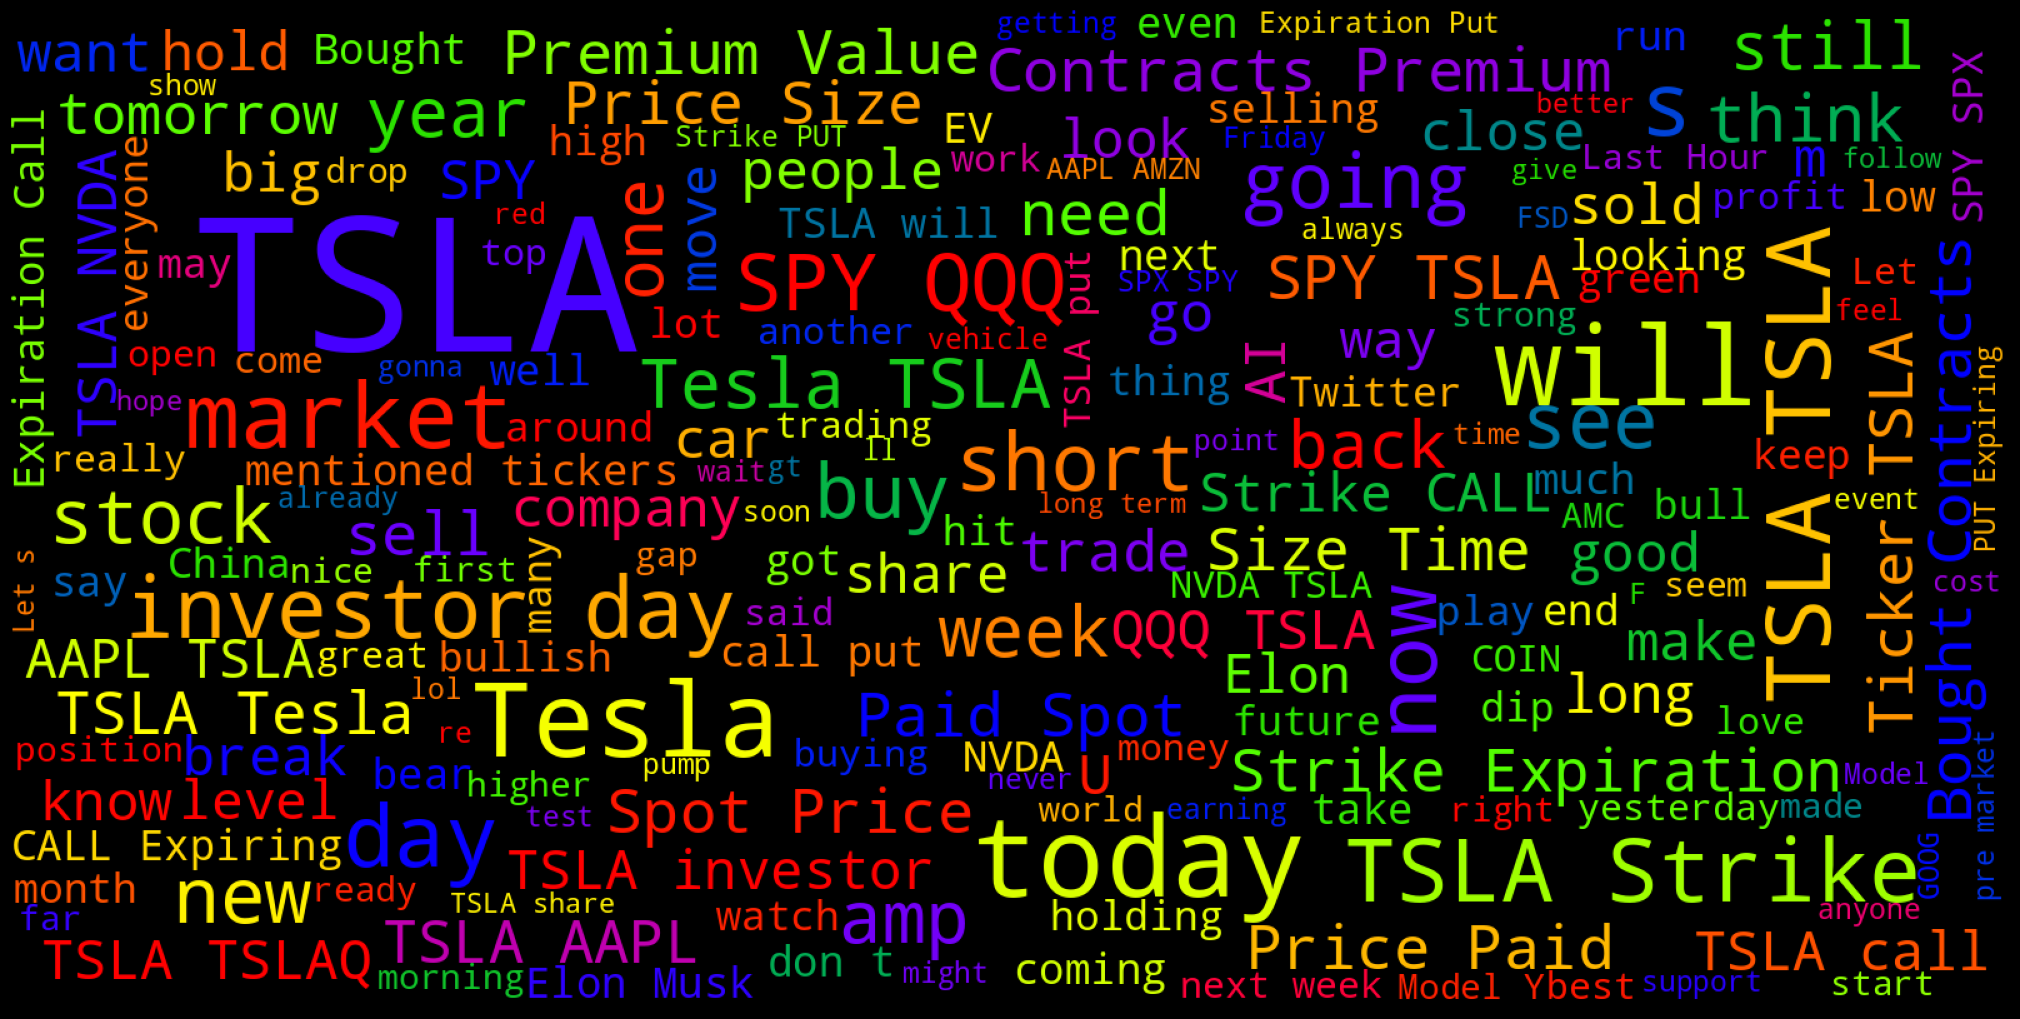

In [262]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([twts for twts in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + query)
word_cloud(df['content'].values)